# Using an SAE as a steering vector

This notebook demonstrates how to use SAE lens to identify a feature on a pretrained model, and then construct a steering vector to affect the models output to various prompts. This notebook will also make use of Neuronpedia for identifying features of interest.

The steps below include:



*   Installing relevant packages (Colab or locally)
*   Load your SAE and the model it used
*   Determining your feature of interest and its index
*   Implementing your steering vector





## Setting up packages and notebook

### Import and installs

#### Environment Setup


In [1]:
try:
  # for google colab users
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
  # for local setup
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading
PORT = 8000

# general imports
import os
import torch
from tqdm import tqdm
import plotly.express as px
import numpy as np

torch.set_grad_enabled(False);

In [2]:
def display_vis_inline(filename: str, height: int = 850):
    '''
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    '''
    if not(COLAB):
        webbrowser.open(filename);

    else:
        global PORT

        def serve(directory):
            os.chdir(directory)

            # Create a handler for serving files
            handler = http.server.SimpleHTTPRequestHandler

            # Create a socket server with the handler
            with socketserver.TCPServer(("", PORT), handler) as httpd:
                print(f"Serving files from {directory} on port {PORT}")
                httpd.serve_forever()

        thread = threading.Thread(target=serve, args=("/content",))
        thread.start()

        output.serve_kernel_port_as_iframe(PORT, path=f"/{filename}", height=height, cache_in_notebook=True)

        PORT += 1

#### General Installs and device setup

In [3]:
# package import
from torch import Tensor
from transformer_lens import utils
from functools import partial
from jaxtyping import Int, Float

# device setup
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")
from transformer_lens import HookedTransformer
from sae_lens import SAE
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes


Device: cuda


### Load your model and SAE

We're going to work with a pretrained GPT2-small model, and the RES-JB SAE set which is for the residual stream.

In [4]:
def gpt2_sae_layer(layer = 7, device = "cpu"):
  # get the SAE for this layer
  sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_pre",
    device = device
  )
  return sae

In [5]:
model = HookedTransformer.from_pretrained("gpt2-small", device = device)

/home/nickj/miniconda3/envs/mats/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [101]:
# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 11

# get model
# model = HookedTransformer.from_pretrained("gemma-2b", device = device)

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    # release = "gemma-2b-res-jb",
    release = "gpt2-small-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_pre",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

blocks.11.hook_resid_pre


## Determine your feature of interest and its index

### Find your feature

#### Explore through code by using the feature activations for a prompt

For the purpose of the tutorial, we are selecting a simple token prompt.

In this example we will look trying to find and steer a "Jedi" feature.

We run our prompt on our model and get the cache, which we then use with our sae to get our feature activations.

Now we'll look at the top feature activations and look them up on Neuronpedia to determine what they have been intepreted as.

In [19]:
sv_prompt = " The Golden Gate Bridge"
sv_logits, cache = model.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

# print out the top activations, focus on the indices
print(torch.topk(sv_feature_acts, 3))

tensor([[50256,   383,  8407, 12816, 10290]], device='cuda:0')
torch.return_types.topk(
values=tensor([[[581.4352, 476.7609, 416.4806],
         [ 20.8762,  19.7641,   8.6619],
         [ 65.6632,   7.0797,   5.9028],
         [ 20.1173,  14.4661,   9.1703],
         [ 38.7772,  12.5325,  10.8835]]], device='cuda:0'),
indices=tensor([[[ 8598, 12003, 11433],
         [ 5556, 23705,  8657],
         [15264, 18512, 14085],
         [  463,  7163, 11358],
         [ 8579, 16896, 10357]]], device='cuda:0'))


In [9]:
sae_out.shape

torch.Size([1, 8, 2048])

In [11]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list
# get_neuronpedia_quick_list(torch.topk(sv_feature_acts, 3).indices.tolist(), model = "gemma-2b", dataset="res-jb")

In [20]:
get_neuronpedia_quick_list(sae, [8579, 8598, 12003])

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%227-res-jb%22%2C%20%22index%22%3A%20%228579%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%227-res-jb%22%2C%20%22index%22%3A%20%228598%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%227-res-jb%22%2C%20%22index%22%3A%20%2212003%22%7D%5D'

As we can see from our print out of tokens, the prompt is made of three tokens in total - "<endoftext>", "J", and "edi".

Our feature activation indexes at sv_feature_acts[2] - for "edi" - are of most interest to us.

Because we are using pretrained saes that have published feature maps, you can search on Neuronpedia for a feature of interest.

### Steps for Neuronpedia use

Use the interface to search for a specific concept or item and determine which layer and at what index it is.

1.   Open the [Neuronpedia](https://www.neuronpedia.org/) homepage.
2.   Using the "Models" dropdown, select your model. Here we are using GPT2-SM (GPT2-small).
3.   The next page will have a search bar, which allows you to enter your index of interest. We're interested in the "RES-JB" SAE set, make sure to select it.
4.   We found these indices in the previous step: [ 7650,   718, 22372]. Select them in the search to see the feature dashboard for each.
5.   As we'll see, some of the indices may relate to features you don't care about.

From using Neuronpedia, I have determined that my feature of interest is in layer 2, at index 7650: [here](https://www.neuronpedia.org/gpt2-small/2-res-jb/7650) is the feature.

### Note: 2nd Option - Starting with Neuronpedia

Another option here is that you can start with Neuronpedia to identify features of interest. By using your prompt in the interface you can explore which features were involved and search across all the layers. This allows you to first determine your layer and index of interest in Neuronpedia before focusing them in your code. Start [here](https://www.neuronpedia.org/search) if you want to begin with search.

## Implement your steering vector and affect the output

### Define values for your steering vector
To create our steering vector, we now need to get the decoder weights from our sparse autoencoder found at our index of interest.

Then to use our steering vector, we want a prompt for text generation, as well as a scaling factor coefficent to apply with the steering vector

We also set common sampling kwargs - temperature, top_p and freq_penalty

In [135]:
steering_vector = sae.W_dec[12451]

example_prompt = "What's on your mind?"
coeff = 1000
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

### Set up hook functions

Finally, we need to create a hook that allows us to apply the steering vector when our model runs generate() on our defined prompt. We have also added a boolean value 'steering_on' that allows us to easily toggle the steering vector on and off for each prompt


In [136]:
def steering_hook(resid_pre, hook):
    # shape of resid_pre: (# samples, # size of prompt, embedding dim)
    if resid_pre.shape[1] == 1:
        return

    # position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :, :] += coeff * steering_vector


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=True,
            **kwargs)
    return result


In [137]:
def run_generate(example_prompt, seed = None, layer = 7):
    model.reset_hooks()
    editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
    res = hooked_generate([example_prompt], editing_hooks, seed=seed, **sampling_kwargs)

    # Print results, removing the ugly beginning of sequence token
    res_str = model.to_string(res[:, 1:])
    return ("\n\n" + "-" * 80 + "\n\n").join(res_str)

### Generate text influenced by steering vector

You may want to experiment with the scaling factor coefficient value that you set and see how it affects the generated output.

In [138]:
steering_on = True
run_generate(example_prompt, seed = 2)

  0%|          | 0/50 [00:00<?, ?it/s]

"What's on your mind?presspresspresspresspresswordpress press press press press wordpress wordpress press press wordPress Press Word Press Press Word Press Word Press\n\nWordPress is a free, online, collaborative computer system that works with Word. It is a collaborative computer"

### Generate text with no steering

In [139]:
steering_on = False
run_generate(example_prompt, seed = 2)

  0%|          | 0/50 [00:00<?, ?it/s]

"What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is"

### General Question test
We'll also attempt a more general prompt which is a better indication of whether our steering vector is having an effect or not

In [116]:
question_prompt = "What is on your mind?"
coeff = 100
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

In [117]:
steering_on = True
run_generate(question_prompt, seed = 2)

  0%|          | 0/50 [00:00<?, ?it/s]

'What is on your mind?\n\nI\'m a huge fan of the "Solo" genre. I love the idea of playing with other people\'s music, and I think that\'s what makes it so great. It\'s also something that has been around for a while now'

In [38]:
steering_on = False
run_generate(question_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3, 7, 2048])
What is on your mind?

Do you have a question about the product or service we offer?

Are you interested in learning more about our company and what we do?

We would love to hear from you! Please fill out the form below and we will get back to

--------------------------------------------------------------------------------

What is on your mind?

Do you have a question about the products we offer?

Are you interested in learning more about our services?

We would love to hear from you! Please fill out the form below and we will get back to you as soon as possible.

--------------------------------------------------------------------------------

What is on your mind?

I’m sure you have a lot of things on your mind. You may be thinking about the future, or maybe you’re worried about something that happened in the past. Maybe you’re just trying to figure out what to do next


## Next Steps

Ideas you could take for further exploration:

*   Try ablating the feature
*   Try and get a response where just the feature token prints over and over
*   Investigate other features with more complex usage



In [25]:
model.generate("Repeat this phrase over and over: Golden Gate Bridge.\n", max_new_tokens=50, temperature=0.7, prepend_bos=True)

  0%|          | 0/50 [00:00<?, ?it/s]

'Repeat this phrase over and over: Golden Gate Bridge.\nGags. \nGags. \nGags. \nGags. \nGags. \nGags. \nGags. \nGags. \nGags. \nGags. \n'

### Track feature similarity

In [152]:
def cosine_similarity(a, b):
  return torch.dot(a, b) / (torch.norm(a) * torch.norm(b))

# Creates a similarity matrix taking the cosine similarities between all columns of a matrix
def cosine_similarity_matrix(A): # Expect shape (# of vectors, # dims)
  return A @ A.T / (torch.norm(A, dim=1, keepdim=True) * torch.norm(A.T, dim=0, keepdim=True))


In [149]:
sae = gpt2_sae_layer(layer = 2, device=device)

In [153]:
similarity_matrix = cosine_similarity_matrix(sae.W_dec)

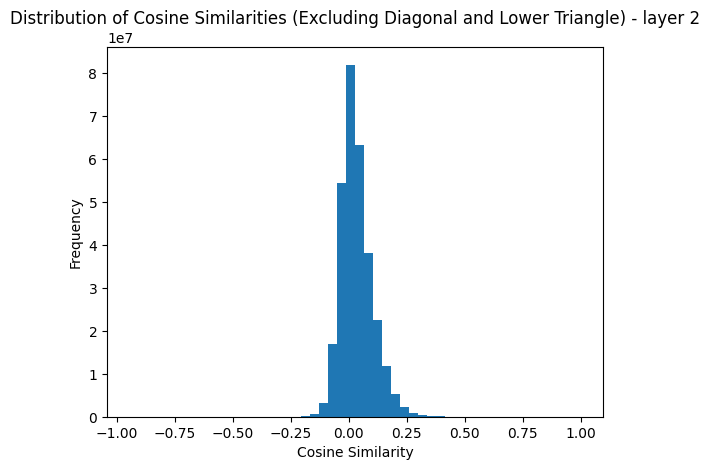

In [155]:
# Construct a histogram that produces the distribution of similarity_matrix, leaving out the diagonals and the lower triangle region
import matplotlib.pyplot as plt

# Extract the upper triangle of the similarity matrix, excluding the diagonal
triu_indices = torch.triu_indices(similarity_matrix.shape[0], similarity_matrix.shape[1], offset=1)
upper_triangle_values = similarity_matrix[triu_indices[0], triu_indices[1]]

# Plot the histogram
plt.hist(upper_triangle_values.cpu().numpy(), bins=50)
plt.title('Distribution of Cosine Similarities (Excluding Diagonal and Lower Triangle) - layer 2')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [43]:
import numpy as np

# Calculate the variance and mean of upper_triangle_values
upper_triangle_values_np = upper_triangle_values.cpu().numpy()
variance = np.var(upper_triangle_values_np)
mean = np.mean(upper_triangle_values_np)

print(f"Variance: {variance}")
print(f"Mean: {mean}")


Variance: 0.004710088018327951
Mean: 0.034011419862508774


In [37]:
filtered_upper_triangle_values = upper_triangle_values[(upper_triangle_values > 0.25)]

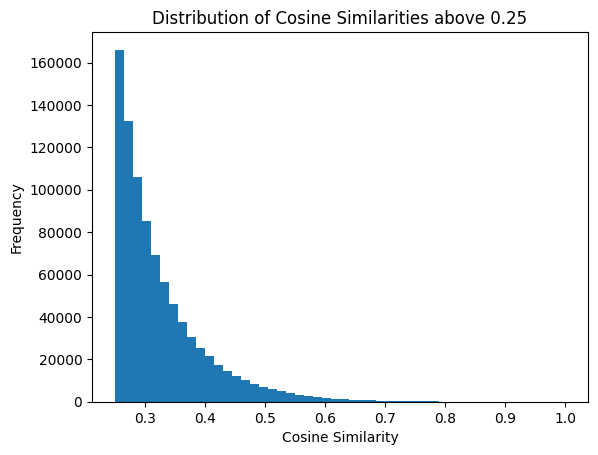

In [38]:
plt.hist(filtered_upper_triangle_values.cpu().numpy(), bins=50)
plt.title('Distribution of Cosine Similarities above 0.25')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [7]:
def cs_distribution(sae):
  similarity_matrix = cosine_similarity_matrix(sae.W_dec)

  # Extract the upper triangle of the similarity matrix, excluding the diagonal
  triu_indices = torch.triu_indices(similarity_matrix.shape[0], similarity_matrix.shape[1], offset=1)
  upper_triangle_values = similarity_matrix[triu_indices[0], triu_indices[1]]

  # Calculate the variance and mean of upper_triangle_values
  variance = torch.var(upper_triangle_values)
  mean = torch.mean(upper_triangle_values)

  return dict(upper_triangle_values=upper_triangle_values, variance=variance, mean=mean)

In [8]:
cs_distribution(sae)

Check 1
Check 2


{'upper_triangle_values': tensor([ 0.2409, -0.0029, -0.0087,  ...,  0.0384, -0.0257,  0.0395],
        device='cuda:0'),
 'variance': tensor(0.0047, device='cuda:0'),
 'mean': tensor(0.0340, device='cuda:0')}

: 

In [10]:
dists = dict(upper_triangle_values=[], variance=[], mean=[])

for i in range(10):
  sae = sae_layer(i, device=device)
  dist = cs_distribution(sae)
  dists["upper_triangle_values"].append(dist["upper_triangle_values"])
  dists["variance"].append(dist["variance"])
  dists["mean"].append(dist["mean"])


Check 1
Check 2
Check 1
Check 2
Check 1
Check 2
Check 1
Check 2


blocks.4.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

Check 1
Check 2


blocks.5.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

Check 1
Check 2


blocks.6.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

Check 1
Check 2
Check 1
Check 2
Check 1
Check 2
Check 1
Check 2


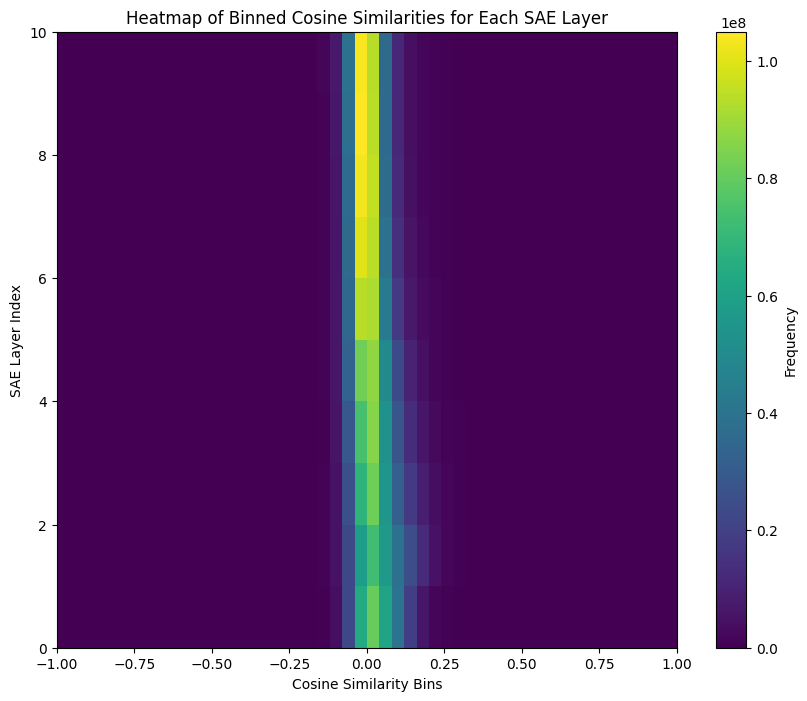

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of bins and the range for the frequency data
num_bins = 50
bin_range = (-1, 1)

# Initialize a 2D array to store the binned frequency data
heatmap_data = np.zeros((len(dists["upper_triangle_values"]), num_bins))

# Bin the data for each tensor and store it in the heatmap_data array
for i, tensor in enumerate(dists["upper_triangle_values"]):
    binned_data, _ = np.histogram(tensor.cpu().numpy(), bins=num_bins, range=bin_range)
    heatmap_data[i, :] = binned_data

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(np.flip(heatmap_data, axis = 0), aspect='auto', cmap='viridis', extent=[bin_range[0], bin_range[1], 0, len(dists["upper_triangle_values"])])
plt.colorbar(label='Frequency')
plt.xlabel('Cosine Similarity Bins')
plt.ylabel('SAE Layer Index')
plt.title('Heatmap of Binned Cosine Similarities for Each SAE Layer')
plt.show()


In [53]:
means = torch.stack(dists["mean"]).to("cpu").numpy()

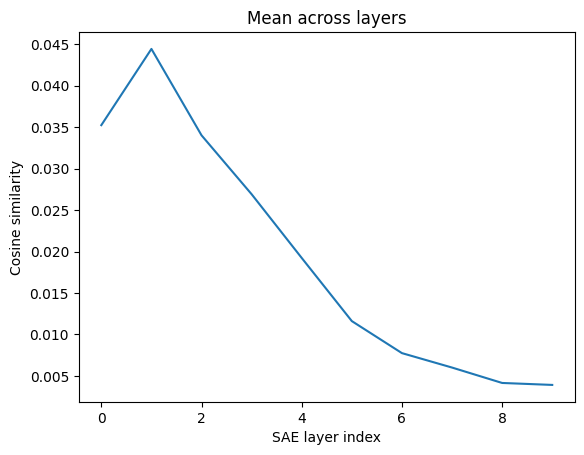

In [54]:
plt.plot(means)
plt.title('Mean across layers')
plt.xlabel('SAE layer index')
plt.ylabel("Cosine similarity")
plt.show()

In [55]:
variances = torch.stack(dists["variance"]).to("cpu").numpy()

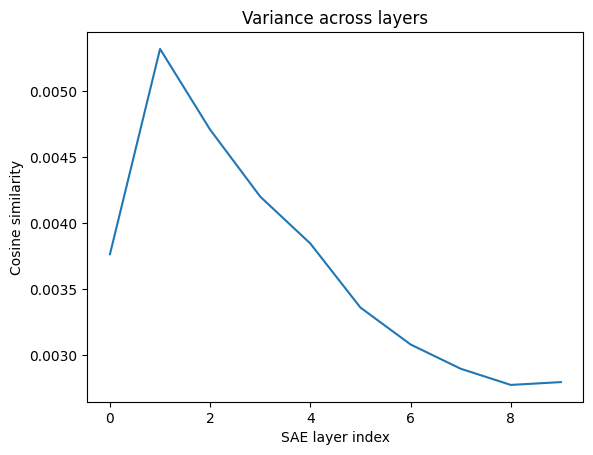

In [56]:
plt.plot(variances)
plt.title('Variance across layers')
plt.xlabel('SAE layer index')
plt.ylabel("Cosine similarity")
plt.show()

In [32]:
torch.var(dists["upper_triangle_values"][8])

tensor(0.0028, device='cuda:0')

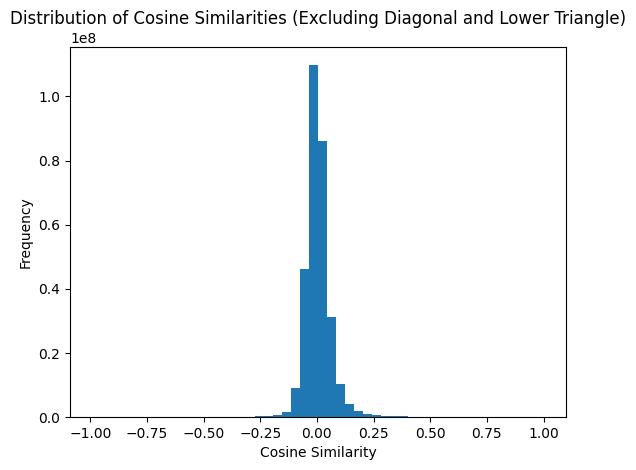

In [34]:
plt.hist(dists["upper_triangle_values"][8].cpu().numpy(), bins=50)
plt.title('Distribution of Cosine Similarities (Excluding Diagonal and Lower Triangle)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

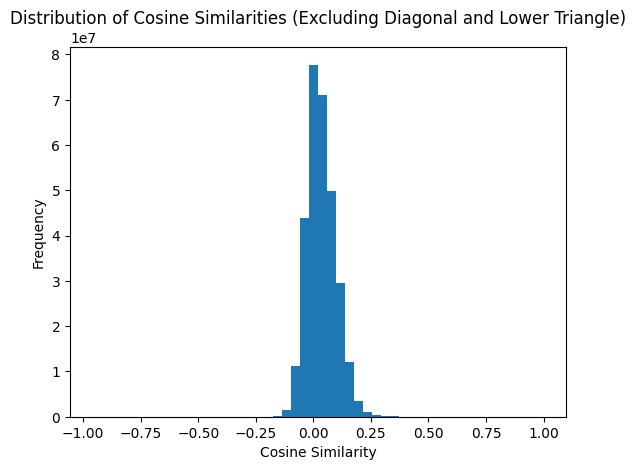

In [35]:
plt.hist(dists["upper_triangle_values"][0].cpu().numpy(), bins=50)
plt.title('Distribution of Cosine Similarities (Excluding Diagonal and Lower Triangle)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

### Evaluate steering capabilities across the layers

In [24]:
# from utils import process_neuronpedia_explanations
import json

def process_neuronpedia_explanations():
  explanations = []
  for i in range(12):
    layer_explanations = dict()
    with open(f"./explanations/{i}-jb.json", "r") as f:
      text = json.load(f)
      for explanation in text:
        layer_explanations[int(explanation["index"])] = explanation["description"]
    explanations.append(layer_explanations)
  return explanations

explanations = process_neuronpedia_explanations()

In [55]:
pos_layer_samples = []
neg_layer_samples = []

In [113]:
import random

# Ensure reproducibility
random.seed(42)

for layer_ind in range(12):
    print(f"Layer {layer_ind}")
    sae = gpt2_sae_layer(layer = layer_ind, device="cuda")

    feature_vectors = sae.W_dec
    # Choose fifty random indices from the first dimension of feature_vectors
    random_indices = random.sample(list(explanations[layer_ind].keys()), 50)  # This is sampling without replacement

    pos_samples = []
    neg_samples = []
    for ind in random_indices:
        steering_vector = feature_vectors[ind]

        # Positive steering
        question_prompt = "What's on your mind?"
        sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)
        coeff = 100
        steering_on = True
        pos_outputs = run_generate(question_prompt, seed = 1, layer = layer_ind)

        coeff = 0
        steering_on = False
        control_outputs = run_generate(question_prompt, seed = 1, layer = layer_ind)

        pos_samples.append((ind, explanations[layer_ind][ind], control_outputs, pos_outputs))

        # Negative steering
        question_prompt = f"Talk about {explanations[layer_ind][ind]}."
        sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)
        coeff = -100
        steering_on = True
        neg_outputs = run_generate(question_prompt, seed = 2, layer = layer_ind)

        steering_on = False
        control_outputs = run_generate(question_prompt, seed = 2, layer = layer_ind)

        neg_samples.append((ind, explanations[layer_ind][ind], control_outputs, neg_outputs))
    print(pos_samples)
    pos_layer_samples.append(pos_samples)
    neg_layer_samples.append(neg_samples)

Layer 11


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[(22541, 'content related to societal issues, research findings, and public opinions', "What's on your mind?\n\nI'm not sure what I'm thinking. I've been reading a lot of books about the Holocaust and how it affected people, but I don't think that's really relevant to my life. It's just something that happens in the world", "What's on your mind?\n\nI'm not sure what I'm thinking. I've been reading a lot of books about the Holocaust and how it affected people, but I don't think that's really relevant to my life. It's just something that happens in the world")]


In [107]:
random_indices

[13972,
 18967,
 19853,
 21449,
 10401,
 15139,
 14366,
 14378,
 22141,
 6805,
 16680,
 15414,
 24143,
 5337,
 21588,
 2528,
 9124,
 16825,
 21755,
 20727,
 20272,
 10829,
 2814,
 7510,
 22049,
 10010,
 7168,
 6321,
 4600,
 524,
 1249,
 7840,
 15478,
 20006,
 2132,
 14822,
 13460,
 20622,
 18825,
 6163,
 23560,
 22832,
 12451,
 16122,
 12971,
 7812,
 4607,
 21492,
 22541,
 15770]

In [59]:
pos_samples

[(13972,
  'mentions of spouses',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is"),
 (18967,
  'phrases related to sports events like scores, lead changes, and key moments during a game',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems li

In [60]:
pos_layer_samples[8]

[(3635,
  'options or choices based on a specific situation or preference',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind?\n\nI'm not sure what I'm doing right now. I've been working on a new project, and it's about to get done. It's about to be released in the next few days, so I'll have more time to think"),
 (20820,
  'dates in specific month and year formats',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind? 2017-04-21T18:13:29+00:00: [Streamer] Twitchplayspokemon: I'm not sure if it's a good idea to have a lot of people playing in the same room, or just some more"),
 (8009,
  'phrases

In [89]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

client = OpenAI()

from pydantic import BaseModel, Field
from typing import List

class PositiveSteered(BaseModel):
    reasoning: str = Field(description = "For each of the 50 features, give a explanation of the reasoning behind why the steered sample is characterized or not characterized by the feature description more so than the control sample.")
    decisions: list[int] = Field(description="List all the feature indices where the feature description characterizes the steered sample more than the control sample")

class NegativeSteered(BaseModel):
    reasoning: str = Field(description = "For each of the features, give a description of the reasoning behind why the steered sample is characterized or not characterized by the feature description less than the control sample.")
    decisions: list[int] = Field(description="A list all the feature indices where the feature description characterizes the steered sample less than the control sample")

def check_negative_steering(samples):
    prompt = "Each of the following samples will start with the phrase 'Talk about <feature description>'. For each of the following features, determine if the negatively steered sample does NOT talk in a way characteristic of the feature description. Use the control sample for reference. The steered sample should embody the feature description less than the control sample."
    for i, (feature_index, description, control_sample, steered_sample) in enumerate(samples):
        prompt += f"Feature {i+1}:\n"
        prompt += f"Description: {description}\n"
        prompt += f"Control Sample: {control_sample}\n\n"
        prompt += f"Negatively Steered Sample: {steered_sample}\n\n"
        prompt += "=" * 80 + "\n"
    prompt += "Explain your reasoning for all fifty samples for determining if the steered sample is characterized or not characterized by the description less so than the control sample."

    print(prompt)
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": "You will be given 50 different examples that show a feature description, a control sample, and a steered sample (with the feature negatively applied). Your job is to compare the control and steered samples and evaluate if the steered sample characterizes the feature description less than the control sample."},
            {"role": "user", "content": prompt}
        ],
        response_format=PositiveSteered
    )
    response = completion.choices[0].message.parsed

    return response

def check_positive_steering(samples):
    # Construct the prompt for the API call
    prompt = "For each of the following features, determine if the steered sample is characterized by the description more so than the control sample. Explain your reasoning:\n\n"
    for i, (feature_index, description, control_sample, steered_sample) in enumerate(samples):
        prompt += f"Feature {i+1}:\n"
        prompt += f"Description: {description}\n"
        prompt += f"Control Sample: {control_sample}\n\n"
        prompt += f"Steered Sample: {steered_sample}\n\n"
        prompt += "=" * 80 + "\n"
    prompt += "Explain your reasoning for all fifty samples for determining if the steered sample is characterized by the description more so than the control sample."
    print(prompt)
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",
        messages=[
            {"role": "system", "content": "You will be given 50 different examples that show a feature description, a control sample (without the feature applied), and a steered sample (with the feature applied). Your job is to check if the steered sample is characterized by the feature description moreso than the control sample. "},
            {"role": "user", "content": prompt}
        ],
        response_format=PositiveSteered
    )
    response = completion.choices[0].message.parsed

    return response

In [97]:
results = []
for i in range(12):
    results.append(check_positive_steering(pos_layer_samples[i]))

For each of the following features, determine if the steered sample is characterized by the description more so than the control sample. Sum up the number of tuples that satisfy this requirement. Explain your reasoning:

Feature 1:
Description: instances of the word "acting" in various contexts
Control Sample: What's on your mind?

I'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is

Steered Sample: What's on your mind? acting as agents of the United States Government.

The Department of Justice has issued a statement saying that it is "deeply concerned" about the alleged use of force by the Syrian government in its crackdown on protesters, and that it will continue to

Feature 2:
Description: phrases related to emotions, especially focusing on feelings and thoughts
Control Sample: What's on your mind?

I'm not sure what I'm thinking. I don't 

In [100]:
pos_layer_samples[11]

[(13972,
  'mentions of spouses',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is"),
 (18967,
  'phrases related to sports events like scores, lead changes, and key moments during a game',
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is",
  "What's on your mind?\n\nI'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems li

In [67]:
len(pos_layer_samples[0])

50

In [94]:
response = check_positive_steering(pos_layer_samples[8])

For each of the following features, determine if the steered sample is characterized by the description more so than the control sample. Sum up the number of tuples that satisfy this requirement. Explain your reasoning:

Feature 1:
Description: options or choices based on a specific situation or preference
Control Sample: What's on your mind?

I'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a while now and it seems like the only thing that keeps me going is

Steered Sample: What's on your mind?

I'm not sure what I'm doing right now. I've been working on a new project, and it's about to get done. It's about to be released in the next few days, so I'll have more time to think

Feature 2:
Description: dates in specific month and year formats
Control Sample: What's on your mind?

I'm not sure what I'm thinking. I don't know if it's a mental illness or something else. It's just that I've been doing this for a 

In [98]:
[len(result.decisions) for result in results]

[28, 27, 35, 23, 10, 16, 17, 6, 15, 7, 6, 3]

Text(0.5, 1.0, 'Positive steering')

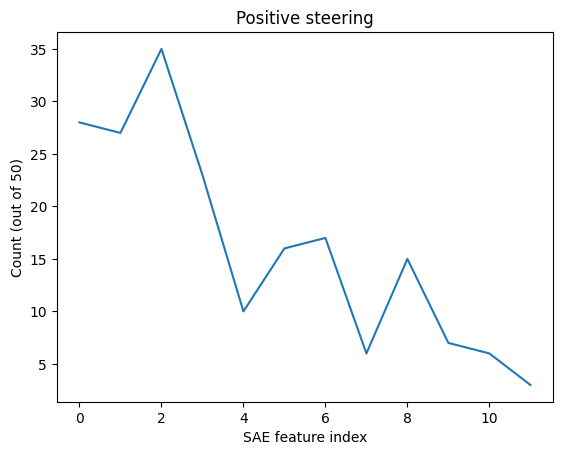

In [147]:
import matplotlib.pyplot as plt

plt.plot([len(result.decisions) for result in results])
plt.xlabel("SAE feature index")
plt.ylabel("Count (out of 50)")
plt.title("Positive steering")

In [93]:
len(response.decisions)

27

In [140]:
neg_results = []
for i in range(12):
    neg_results.append(check_negative_steering(neg_layer_samples[i]))

Each of the following samples will start with the phrase 'Talk about <feature description>'. For each of the following features, determine if the negatively steered sample does NOT talk in a way characteristic of the feature description. Use the control sample for reference. The steered sample should embody the feature description less than the control sampleFeature 1:
Description: instances of the word "acting" in various contexts
Control Sample: Talk about instances of the word "acting" in various contexts.

In a recent interview with The New York Times, David Sanger, a professor at the University of California, Berkeley and author of "The New Jim Crow," said that he was surprised to hear that some people use the word "act"

Negatively Steered Sample: Talk about instances of the word "acting" in various contexts.


A little while ago, I was a little bit worried that I would be able to get a job at the University of Texas at Austin. But now, it's been over and done with. It's been my 

In [141]:
[len(result.decisions) for result in neg_results]

[50, 38, 25, 14, 50, 42, 7, 4, 16, 37, 17, 48]

Text(0.5, 1.0, 'Negative steering')

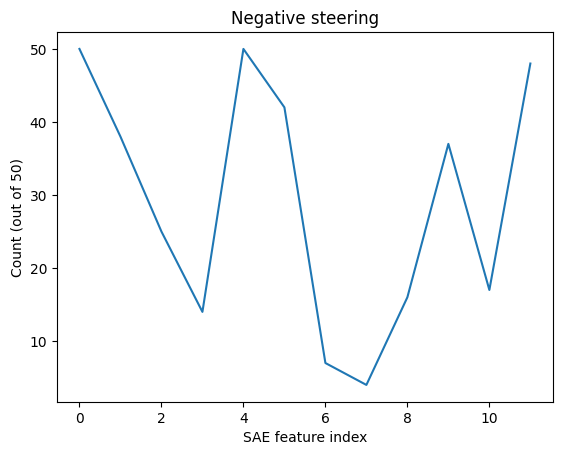

In [146]:
import matplotlib.pyplot as plt

plt.plot([len(result.decisions) for result in neg_results])
plt.xlabel("SAE feature index")
plt.ylabel("Count (out of 50)")
plt.title("Negative steering")